In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/project2/drugsComTest_raw.tsv
/kaggle/input/project2/drugsComTrain_raw.tsv


In [2]:
df=pd.read_csv('/kaggle/input/project2/drugsComTrain_raw.tsv',sep='\t')

In [100]:
df.describe()

,Unnamed: 0,rating,usefulCount
count,161297.000000,161297.000000,161297.000000
mean,115923.585305,6.994377,28.004755
std,67004.445170,3.272329,36.403742
min,2.000000,1.000000,0.000000
25%,58063.000000,5.000000,6.000000
50%,115744.000000,8.000000,16.000000
75%,173776.000000,10.000000,36.000000
max,232291.000000,10.000000,1291.000000


In [101]:
df.isnull().sum()

Unnamed: 0       0
drugName         0
condition      899
review           0
rating           0
date             0
usefulCount      0
dtype: int64

In [3]:
df.dropna(inplace=True)

In [4]:
df.drop(['Unnamed: 0','date'],axis=1,inplace=True)

In [104]:
condition_df=df.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
condition_df=pd.DataFrame(condition_df).reset_index()

In [105]:
condition_df

,condition,drugName
0,Not Listed / Othe,214
1,Pain,200
2,Birth Control,172
3,High Blood Pressure,140
4,Acne,117
...,...,...
879,ailure to Thrive,1
880,ge (amlodipine / valsartan),1
881,ge HCT (amlodipine / hydrochlorothiazide / val...,1
882,ibrocystic Breast Disease,1


In [6]:
count_df=df[['condition','review']].groupby('condition').aggregate({'review':'count'}).reset_index().sort_values('review',ascending=False)
count_df

,condition,review
165,Birth Control,28788
262,Depression,9069
594,Pain,6145
125,Anxiety,5904
80,Acne,5588
...,...,...
60,76</span> users found this comment helpful.,1
61,77</span> users found this comment helpful.,1
62,79</span> users found this comment helpful.,1
64,84</span> users found this comment helpful.,1


In [7]:
target=count_df[count_df['review']>3000]['condition'].values

In [8]:
def condition_parser(x):
    if x in target:
        return x
    else:
        return 'OTHER'
df['condition']=df['condition'].apply(lambda x: condition_parser(x))

In [9]:
df=df[df['condition']!='OTHER']

In [12]:
from nltk.stem.snowball import SnowballStemmer

In [13]:
stemmer = SnowballStemmer('english')

def review_to_words(raw_review):
    # 1. Delete HTML
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. Make a space
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. lower letters
    words = letters_only.lower().split()
    # 6. Stemming
    stemming_words = [stemmer.stem(w) for w in words]
    # 7. space join words
    return ' '.join(stemming_words)

# 딥러닝

In [20]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from bs4 import BeautifulSoup
import re

df['review_cleane']=df['review'].apply(review_to_words)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['review_clean'])
sequences = tokenizer.texts_to_sequences(df['review_clean'])

max_sequence_length = max(len(x) for x in sequences)
X = pad_sequences(sequences, maxlen=max_sequence_length)

label_encoder_condition = LabelEncoder()
label_encoder_drug = LabelEncoder()

y_condition = label_encoder_condition.fit_transform(df['condition'])
# y_drugName = label_encoder_drug.fit_transform(df['drugName'])
y_condition = pd.get_dummies(y_condition).values
# y_drugName = pd.get_dummies(y_drugName).values
# X_train, X_val, y_condition_train, y_condition_val, y_drugName_train, y_drugName_val = train_test_split(
#     X, y_condition, y_drugName, test_size=0.2, random_state=42)
x_train,x_test,y_train,y_test=train_test_split(X,y_condition,test_size=0.2,random_state=42)

print(x_train.shape,x_test.shape)

(59160, 1099) (14791, 1099)


In [32]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense,Input,LSTM,Embedding,Dropout,Activation,Conv1D,Bidirectional,GlobalMaxPool1D
from tensorflow.keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

2024-04-07 14:00:01.970044: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-07 14:00:01.970171: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-07 14:00:02.105779: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [113]:
len(y_condition[0])

10

In [132]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense

input_layer = Input(shape=(max_sequence_length,))
embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128)(input_layer)
lstm_layer = LSTM(64)(embedding_layer)
condition_output = Dense(len(label_encoder_condition.classes_), activation='softmax', name='condition_output')(lstm_layer)
# drug_output = Dense(len(label_encoder_drug.classes_), activation='softmax', name='drug_output')(lstm_layer)
model = Model(inputs=input_layer, outputs=condition_output)
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [191]:
history = model.fit(x_train, y_train,validation_data=(x_test, y_test), epochs=10, batch_size=128)


Epoch 1/10
463/463 ━━━━━━━━━━━━━━━━━━━━ 36s 76ms/step - accuracy: 0.4419 - loss: 1.9074 - val_accuracy: 0.7594 - val_loss: 0.6747
Epoch 2/10
463/463 ━━━━━━━━━━━━━━━━━━━━ 35s 75ms/step - accuracy: 0.7985 - loss: 0.5817 - val_accuracy: 0.8374 - val_loss: 0.4591
Epoch 3/10
463/463 ━━━━━━━━━━━━━━━━━━━━ 35s 76ms/step - accuracy: 0.8572 - loss: 0.4012 - val_accuracy: 0.8590 - val_loss: 0.3923
Epoch 4/10
463/463 ━━━━━━━━━━━━━━━━━━━━ 35s 75ms/step - accuracy: 0.8922 - loss: 0.3042 - val_accuracy: 0.8734 - val_loss: 0.3552
Epoch 5/10
463/463 ━━━━━━━━━━━━━━━━━━━━ 35s 75ms/step - accuracy: 0.9115 - loss: 0.2555 - val_accuracy: 0.8745 - val_loss: 0.3495
Epoch 6/10
463/463 ━━━━━━━━━━━━━━━━━━━━ 35s 75ms/step - accuracy: 0.9220 - loss: 0.2247 - val_accuracy: 0.8830 - val_loss: 0.3377
Epoch 7/10
463/463 ━━━━━━━━━━━━━━━━━━━━ 35s 75ms/step - accuracy: 0.9357 - loss: 0.1909 - val_accuracy: 0.8853 - val_loss: 0.3554
Epoch 8/10
463/463 ━━━━━━━━━━━━━━━━━━━━ 35s 75ms/step - accuracy: 0.9435 - loss: 0.1718 - 

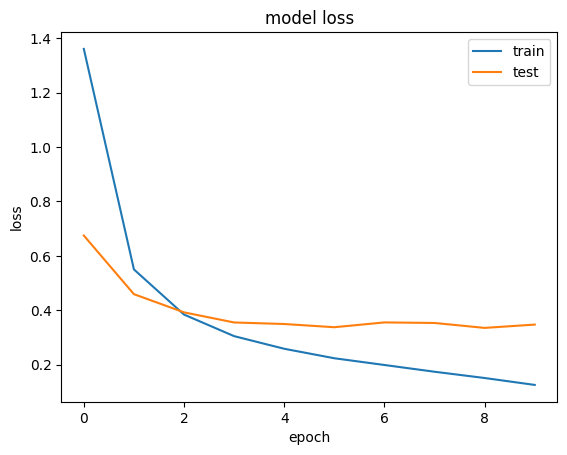

In [192]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('model loss')
plt.legend(['train','test'])
plt.show()

In [118]:
test_loss, test_cond_acc, test_drug_acc = model.evaluate( X_val, {'condition_output': y_condition_val, 'drug_output': y_drugName_val})

print(f"Test Loss: {test_loss}")
print(f"Condition Prediction Accuracy: {test_cond_acc}")
print(f"Drug Name Prediction Accuracy: {test_drug_acc}")


463/463 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - condition_output_accuracy: 0.8826 - drug_output_accuracy: 0.2933 - loss: 3.0749
Test Loss: 3.0822503566741943
Condition Prediction Accuracy: 0.8822256922721863
Drug Name Prediction Accuracy: 0.29450342059135437


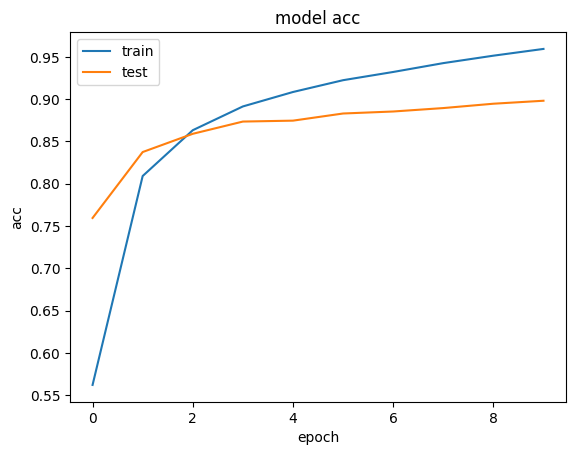

In [193]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['train','test'])
plt.title('model acc')
plt.show()

In [205]:
# new_reviews = ["It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil"]
new_reviews = "It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil"
# new_reviews_cleaned = [review.lower().replace('[^a-zA-Z]', ' ') for review in new_reviews]
new_reviews=list(df['review'][:5])
ans_conditions=list(df['condition'][:5])
for i in range(5):
    new_reviews_cleaned = new_reviews[i].lower().replace('[^a-zA-Z]', ' ')
    new_sequences = tokenizer.texts_to_sequences([new_reviews_cleaned])
    new_padded_sequences = pad_sequences(new_sequences, maxlen=max_sequence_length)
    new_sequences
    pred = model.predict(new_padded_sequences)
    predicted_condition = label_encoder_condition.classes_[np.argmax(pred)] 
    # predicted_drugs = [label_encoder_drug.classes_[np.argmax(pred)] for pred in predictions[1]]

    print(f'Predicted Condition: {predicted_condition}')
    print(f'Answer Condition: {ans_conditions[i]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted Condition: ADHD
Answer Condition: ADHD
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Condition: Birth Control
Answer Condition: Birth Control
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Condition: Birth Control
Answer Condition: Birth Control
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Condition: Bipolar Disorde
Answer Condition: Bipolar Disorde
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted Condition: Birth Control
Answer Condition: Birth Control


# 머신러닝

In [24]:
from bs4 import BeautifulSoup
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report,mean_squared_error

In [16]:
df['review_clean']=df['review'].apply(review_to_words)

/tmp/ipykernel_34/2151439243.py:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(raw_review, 'html.parser').get_text()


In [26]:
vectorizer=TfidfVectorizer(lowercase=True)
X=vectorizer.fit_transform(df['review_clean'])

In [27]:
x_train,x_test,y_train,y_test=train_test_split(X,df['condition'],test_size=0.2,random_state=42)

# Randomforest

In [28]:
from sklearn.ensemble import RandomForestClassifier
model1=RandomForestClassifier()
model1.fit(x_train,y_train)

RandomForestClassifier()

In [29]:
pred=model1.predict(x_test)
print(classification_report(pred,y_test))

                 precision    recall  f1-score   support

           ADHD       0.88      0.96      0.92       626
           Acne       0.89      0.98      0.93      1035
        Anxiety       0.76      0.85      0.80      1012
Bipolar Disorde       0.76      0.95      0.85       659
  Birth Control       1.00      0.92      0.95      6271
     Depression       0.86      0.81      0.83      1915
       Insomnia       0.84      0.90      0.87       652
        Obesity       0.72      0.84      0.78       639
           Pain       0.93      0.92      0.92      1283
    Weight Loss       0.75      0.80      0.78       699

       accuracy                           0.90     14791
      macro avg       0.84      0.89      0.86     14791
   weighted avg       0.90      0.90      0.90     14791



In [31]:
new_review = ["This drug is amazing, it really helped me with my condition!"]
new_review = vectorizer.transform(new_review)
new_condition = model1.predict(new_review)[0]
print("Predicted Condition:", new_condition)

Predicted Condition: Depression


# Gradient Boosting

In [33]:
from sklearn.ensemble import GradientBoostingClassifier
model2=GradientBoostingClassifier()
model2.fit(x_train,y_train)

KeyboardInterrupt: 

# LightGBM

In [34]:
import lightgbm as lgb
model3=lgb.LGBMClassifier()
model3.fit(x_train,y_train)

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.020537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 314606
[LightGBM] [Info] Number of data points in the train set: 59160, number of used features: 3837
[LightGBM] [Info] Start training from score -3.086624
[LightGBM] [Info] Start training from score -2.586668
[LightGBM] [Info] Start training from score -2.517690
[LightGBM] [Info] Start training from score -2.856470
[LightGBM] [Info] Start training from score -0.943795
[LightGBM] [Info] Start training from score -2.095252
[LightGBM] [Info] Start training from score -2.988658
[LightGBM] [Info] Start training from score -3.041030
[LightGBM] [Info] Start training from score -2.497152
[LightGBM] [Info] Start training from score -3.030124


LGBMClassifier()

In [35]:
pred=model3.predict(x_test)
print(classification_report(pred,y_test))

                 precision    recall  f1-score   support

           ADHD       0.93      0.96      0.94       656
           Acne       0.93      0.96      0.95      1093
        Anxiety       0.78      0.83      0.81      1064
Bipolar Disorde       0.82      0.87      0.85       779
  Birth Control       0.99      0.97      0.98      5845
     Depression       0.87      0.80      0.83      1949
       Insomnia       0.88      0.89      0.88       684
        Obesity       0.75      0.81      0.78       683
           Pain       0.94      0.94      0.94      1276
    Weight Loss       0.80      0.79      0.80       762

       accuracy                           0.91     14791
      macro avg       0.87      0.88      0.87     14791
   weighted avg       0.91      0.91      0.91     14791



In [36]:
new_review = ["This drug is amazing, it really helped me with my condition!"]
new_review = vectorizer.transform(new_review)
new_condition = model3.predict(new_review)[0]
print("Predicted Condition:", new_condition)

Predicted Condition: Depression
